<center>
<h1>MetPy’s Choice of Unit Support:<br>A Descent into Madness</h1>
<br>
<h3>14 July 2017
<br>
<br>
Ryan May (@dopplershift)
<br>
John Leeman (@geo_leeman)
<br><br>
UCAR/Unidata</h3>
</center>

# MetPy

- Community toolkit for solving meteorology and atmospheric science problems
- Plotting
- File Formats
- **Calculations**

# Units?
- Handling of physical quantities (aka. "units") important in scientific applications

>The MCO MIB has determined that the root cause for the loss of the MCO spacecraft was the failure to use metric units in the coding of a ground software file, “Small Forces,” used in trajectory models. Specifically, thruster performance data in English units instead of metric units was used in the software application code titled SM_FORCES (small forces).

- To avoid these problems, part of MetPy's core architecture is the use of a unit library, Pint
- Simplifies documentation
- Eliminates manual auditing of units in calculation functions
- Supports data files with arbitrary units (e.g. netCDF) more easily

![tire swing](./TS-57566978_Boy-on-tire-swing_v.jpg.rend.hgtvcom.616.822.jpeg)

# Pint?
- Pure Python unit-handling library
- Wraps Python scalars, lists, or NumPy arrays
- Supports units using offsets (i.e. temperature)
- Alternatives:
  - `astropy.units`
  - `quantities`
  - `cf_units`
  - Many others

## Example usage

In [1]:
import astropy.units as aunits

In [2]:
import metpy.calc as mpcalc
from metpy.units import units

temperature = 75 * units.degF
relative_humidity = 70 * units.percent
mpcalc.dewpoint_rh(temperature, relative_humidity).to('degF')

<Quantity(64.56301588685112, 'degF')>

## Without Pint

```python
from scipy.constants import convert_temperature
temperature = convert_temperature(75, 'F', 'C')
relative_humidity = 0.7
convert_temperature(mpcalc.dewpoint_rh(temperature,
       relative_humidity), 'C', 'F')
```

![Disgusted Clint](clint.gif)

# The End
- Everything just works!

In [3]:
from metpy.constants import Rd
import numpy as np

t_diff = (np.random.randn(10) * units.degC -
          np.random.randn(10) * units.degC)
np.trapz(t_diff)

6.0560018454768532

![fire tire](fire-tire.gif)

# The End--of sanity
- ~~Everything just works!~~

- The only thing worse than not using a unit library...

- ...is trying to use one with Python libraries expecting numpy arrays

- Everything I show broken here is *also* broken for `astropy.units`

# NumPy/SciPy

## Let's start with concatenate

In [4]:
a = np.array([3.])
b = np.array([4.])
np.concatenate((a, b))

array([ 3.,  4.])

- Now what about with units?

In [5]:
a = np.array([3.]) * units.m
b = np.array([4.]) * units.m
np.concatenate((a, b))

array([ 3.,  4.])

- Units dropped because numpy creates a new array for storage
- No way for subclasses/array-like to declare how to make a new instance
- NumPy #4164

## Maybe calculating a gradient?

In [6]:
import numpy as np
a = np.arange(5)
np.gradient(a, 0.1)

array([ 10.,  10.,  10.,  10.,  10.])

With units?

In [7]:
a = np.arange(5) * units.degC
np.gradient(a, 0.1 * units.m)

TypeError: object of type 'float' has no len()

- `np.isscalar()` for a float with units attached returns `False`

## Interpolating: `numpy.interp()`

In [8]:
x = np.arange(5)
y = x
np.interp(1.5, x, y)

1.5

With units?

In [9]:
x = np.arange(5) * units.m
y = x
np.interp(1.5 * units.m, x, y)

ValueError: object of too small depth for desired array

- There's no way the average user is going to figure that out
- Disappears into C code, so not sure where the problem lies...

## What about using scipy optimization?
- Fixed point iteration `scipy.optimize.fixed_point`
- Uses other calculations that need units

```python
from scipy.optimize import fixed_point
def step(p, p0, w, t):
    td = dewpoint(vapor_pressure(p, w))
    return (p0 * (td / t) ** (1. / kappa))

fp = so.fixed_point(step, pressure,
                    args=(pressure, w, temperature))
```

Nope, that doesn't work...

```python
from scipy.optimize import fixed_point
def step(p, p0, w, t):
    td = dewpoint(vapor_pressure(units.Quantity(p, pressure.units), w))
    return (p0 * (td / t) ** (1. / kappa)).magnitude

fp = so.fixed_point(step, pressure.magnitude,
                    args=(pressure.magnitude, w, temperature))
```

- Need to drop units when going into scipy code...

- ...and reattach before going into MetPy code.
![I'm Cool](im_cool.gif)

### Mitigation
- Drop units as necessary when calling functions...
- ...and reattach correct units on the way out
- Essentially subverting all of the unit-handling
- Not *so* bad if we're hiding inside calculation functions

# Matplotlib

In [10]:
%matplotlib inline

## `Plot()`
- Plotting with masked arrays in matplotlib
- Breaks up line nicely around missing points

First with units:

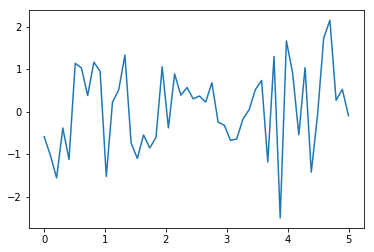

In [11]:
import matplotlib.pyplot as plt
temp_data = np.random.randn(50)
temp_units = temp_data * units.degC
t = np.linspace(0, 5, 50)
plt.plot(t, temp_units)

- Looks good

Now masked arrays, no units:

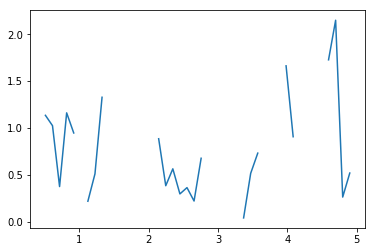

In [12]:
temp_masked = np.ma.masked_array(temp_data, mask=temp_data<0)
plt.plot(t, temp_masked)

- Ok, that's fine

Now what about masked *and* units?

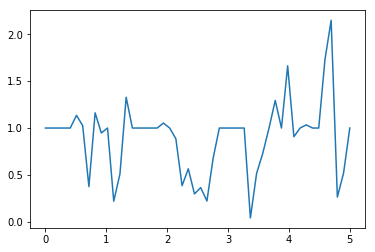

In [13]:
temp_units_masked = temp_masked * units.degC
plt.plot(t, temp_units_masked)

<img style="float: right" src="no-idea.gif" alt="No Idea" width="33%">

<ul style="display: block">
  <li>I have no idea what's going on here</li>
  <li>The filling is *not* the original values</li>
</ul>  

## `axhline()`/`axvline()`
- Horizontal/Vertical line spanning the entire axis
- Matplotlib has built-in support for unit conversions
- In theory, allows plotting data with one unit but request axes in another
- Let's see how this works

```python
plt.axhline(0 * units.degC)
```

```pytb
ValueError: Cannot compare Quantity and <class 'numpy.float64'>
```

- Problem is comparison between plotted value and plot limits
- Enabling Matplotlib's unit-conversion behavior doesn't help
- There is literally no code path through that allows the proper comparison with unit-ed values

## Mitigation
- Register with matplotlib's unit-handling...

- ...but use that to automatically drop units for every plotting function
![Bang Computer](beating_computer.gif)

# Xarray

- Xarray provides labeled axes for nd-grids
- Sort of works with units?

In [14]:
import xarray as xr
data = xr.DataArray([1, 2, 3], dims=('x',), coords={'x':[1, 2, 3]})
units.m * data

<Quantity(<xarray.DataArray (x: 3)>
array([1, 2, 3])
Coordinates:
  * x        (x) int64 1 2 3, 'meter')>

- Ok, but I'm not wild about meters being next to the coordinate values

- Putting units to the right of the data looks more reasonable (to me):

In [15]:
data * units.m

<xarray.DataArray (x: 3)>
array([1, 2, 3])
Coordinates:
  * x        (x) int64 1 2 3

- Oh come on.

![Head Smash](perry-headsmash.gif)

- One way uses `pint.Quantity.__add__`
- The other `xarray.DataArray.__add__`
- I will **not** teach users that the order of multiplication matters

# The end of the story
- This is the current state of things
- There is no happy ending here--I don't have any implemented solutions

- Core problems:
  - `np.(as)array` == "Please silently discard my units"
  - Uses:
    - Convert lists/floats to array
    - Make sure something supports math and slicing
    - Enforce compatibility with numpy C-API
  - Things that *should* be considered arrays aren't
  - Other array-managing libraries need to know about your need for units
  - `np.asanyarray` only helps for subclasses

## Possible solutions
- NumPy's new `__array_ufunc__` support
  - Available in numpy 1.13
  - Improves overriding behavior for ufuncs
  - Not how this plays out for operand order problem (like xarray example)

- NumPy Abstract Base Class(es) (ABCs)
  - Allow other array-like classes to declare they implement certain interface
  - Create separate ABCs for portions of numpy interface
  - `numpy.asarray` can perform `isinstance` check with (one) ABC
  - Will require downstream libraries to migrate away from `asarray` for other ABCs
  - Not sure how this plays with composition between array-like libraries

- Custom NumPy dtypes
  - Modify NumPy C-level code to allow custom datatypes
  - Encode units as part of datatype--then units don't drop
  - Would *probably* solve all of the problems
  - Most technically challenging

# Concluding
- The user experience when trying to substitute for numpy arrays with a unit-ed array is pretty frustrating
- There **has** to be a way to make this work better
- I'm open to suggestions (besides removing our unit support)
- I'm not here to rag on anyone's work, this comes from a place of love...

- ...and immense frustration
![Nerd Rage](nerdrage.gif)